# Business Data Science

Abhilash Vikram Gupta

https://www.kaggle.com/c/mis382n-fall-2019

In [57]:
import numpy as np
import pandas as pd

from functools import partial

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

import xgboost as xgb
import lightgbm as lgbm

from IPython.display import display

In [136]:
df = pd.read_csv('data/train_final.csv', index_col='Id')
df_ult = pd.read_csv('data/test_final.csv', index_col='Id')

X = df.drop('Y', axis='columns').values
y = df['Y'].values

n_features = X.shape[1]

X_ult = df_ult.values

scale_pos_weight = len(y[y == 0])/len(y[y == 1])

## Feature selection

done using forward, backward and a model's feature_importances_.

In [3]:
def get_ind(mask): return [index for index, mask_ele in enumerate(mask) if mask_ele==True]

def get_best_ind(importances, start=7, number=5):
    ranked_features = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
    return [ranked_features[:i] for i in range(start, start + number)]

def get_clf():
#     return lgbm.LGBMClassifier(n_estimators=400,
#                                learning_rate=0.1, 
#                                boosting_type='goss', 
#                                max_depth=5, 
#                                num_leaves=33,
#                                objective='binary', 
#                                scale_pos_weight=scale_pos_weight)
    return xgb.XGBClassifier(max_depth=5, 
                             learning_rate=0.1, 
                             n_estimators=750, 
                             objective='binary:logistic', 
                             tree_method='auto', 
                             eval_metric='auc', 
                             n_jobs=-1, 
                             reg_alpha=0.001,
                             scale_pos_weight=scale_pos_weight)
    

In [83]:
def get_best_features(model, data, step=1):
    rfecv = RFECV(estimator=model, step=step, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
    rfecv.fit(data, y)

    return get_ind(rfecv.ranking_ == 1)

In [79]:
get_best_features(get_clf(), X)

[1, 3, 6, 7, 12, 13, 14, 15, 16, 18, 23]

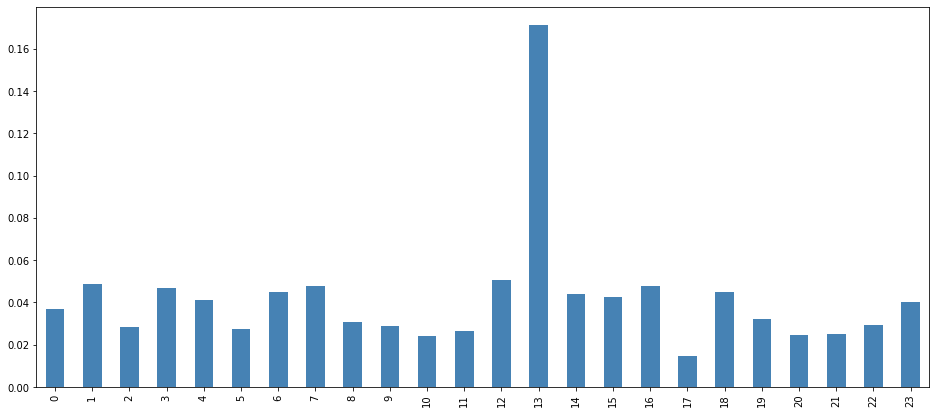

In [24]:
clf = get_clf().fit(X, y)
pd.Series(clf.feature_importances_, index=list(range(X.shape[1]))).plot.bar(color='steelblue', figsize=(16, 7));

#### Conclusions

Based on weighted average and intuition.

In [90]:
# feats_to_try = get_best_ind(clf.feature_importances_)
feats_to_try = [
#     [3, 6, 7, 12, 13, 14, 15],
    [3, 6, 7, 12, 13, 14, 15, 16, 18, 21],
    [3, 6, 7, 12, 13, 14, 15, 16, 18],
    [1, 3, 6, 7, 12, 13, 14, 15, 16, 18, 23] # was best last time
]

## Training

and collection of best models.

In [85]:
# params = {
# 'task':'train',
# 'numleaves': 31, 'objective': 'multiclass', 'numclass':10,
# 'mindatainleaf': 100, 'learningrate': 0.05,
# 'featurefraction': 0.85, 'baggingfraction': 0.85,
# 'baggingfreq': 2, 'metric': 'multierror',
# 'maxbin':128, 'numthreads': 32
# }

# lgb_train = lgb.Dataset(X_train, 
#                         label=y_train,
#                         feature_name=feature_names, 
#                         categorical_feature=categorical_features)

# tuning_parameters = [{'n_estimators':                  [500], 
#                       'boosting_type':                 ['goss'],
#                       'learning_rate':                 [0.1], 
#                       'max_depth':                     [5],
#                       'num_leaves':                    [33],
#                       'objective':                     ['binary'],
#                       'reg_alpha':                     np.logspace(-3, -2, 2),
#                       'reg_lambda':                    [1],
#                       'scale_pos_weight':              [scale_pos_weight]}]

tuning_parameters = [{'max_depth':                      [5], 
                      'learning_rate':                  [0.1], 
                      'n_estimators':                   [728, 735, 742], 
                      'objective':                      ['binary:logistic'], 
                      'booster':                        ['gbtree'],
                      'tree_method':                    ['auto'], 
                      'reg_alpha':                      [0.0011], 
                      'reg_lambda':                     [0.9, 1.2]}]

clfs = []
for feats in feats_to_try:

    grid = GridSearchCV(xgb.XGBClassifier(n_jobs=-1, eval_metric='auc', scale_pos_weight=scale_pos_weight), 
                        tuning_parameters, 
                        cv=StratifiedKFold(5), 
                        scoring='roc_auc', 
                        n_jobs=-1)
    
    grid.fit(X[:, feats], y)
    
    print(f'Best parameters {grid.best_params_}.')
    print(f'Best auc score is {grid.best_score_}.')
    
    clfs.append(grid.best_estimator_)

Best parameters {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 742, 'objective': 'binary:logistic', 'reg_alpha': 0.0011, 'reg_lambda': 1.2, 'tree_method': 'auto'}.
Best auc score is 0.8860748069839841.
Best parameters {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 728, 'objective': 'binary:logistic', 'reg_alpha': 0.0011, 'reg_lambda': 1.2, 'tree_method': 'auto'}.
Best auc score is 0.8831812165578737.
Best parameters {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 728, 'objective': 'binary:logistic', 'reg_alpha': 0.0011, 'reg_lambda': 0.9, 'tree_method': 'auto'}.
Best auc score is 0.8850524446357293.


## Generation

of submissions.

In [91]:
req_rows = 16384

display('Re-training...')
preds_dfs = []
for feats, clf in zip(feats_to_try, clfs):
    clf.fit(X[:, feats], y)
    preds_dfs.append(pd.DataFrame(clf.predict_proba(X_ult[:, feats])[:, 1], 
                          index=list(range(req_rows, req_rows*2 + 1)), 
                          columns=['Y']))

display('Writing...')
for idx, df in enumerate(preds_dfs):
    df.index.name = 'Id'
    df.to_csv(f'submission_24_{idx}.csv')
display('Done.')

'Re-training...'

'Writing...'

'Done.'

In [173]:
def ind_to_name(df, idx): return df.columns[idx].tolist()

def generate_train(dataframe, model):
    train_dataframe = dataframe.drop('Y', axis='columns')
    labels = dataframe['Y']
    
    feature_ratings = model.fit(train_dataframe.values, labels).feature_importances_
    first, second, third = get_best_ind(feature_ratings, 3, 1)[0]
    first_name, second_name, third_name = indices_to_names(train_dataframe, [first, second, third])
    
    train_dataframe[first_name + '*1.5'] = train_dataframe[first_name] ** 1.5
    train_dataframe[first_name + '*2'] = train_dataframe[first_name] ** 2
    
    relevant_columns = train_dataframe[[first_name, second_name, third_name]].values
    scaled = StandardScaler().fit_transform(relevant_columns)
    fused = PCA(n_components=1).fit_transform(scaled[:, 1:]).ravel()
    
    train_dataframe[first_name + '+fused'] = scaled[:, 0] + fused
    train_dataframe[first_name + '-fused'] = scaled[:, 0] - fused
    
    return train_dataframe

def alter_params(params, dec):
    new_params = {}
    new_params['n_estimators'] = [round(params['n_estimators'] + np.ceil(dec/5)), 
                                  params['n_estimators'],
                                  round(params['n_estimators'] - np.ceil(dec/5))]
    new_params['reg_alpha'] = [params['reg_alpha'] * (1 + (0.005 * dec)),
                               params['reg_alpha'],
                               params['reg_alpha'] * (1 - (0.005 * dec))]
    new_params['reg_lambda'] = [params['reg_lambda'] + (0.001 * dec), 
                                params['reg_lambda'], 
                                params['reg_lambda'] - (0.001 * dec)]
    return new_params

results_dataframe = pd.DataFrame(columns=['score', 'params', 'features', 'dec'])

const_params = {
    'max_depth':                      5, 
    'learning_rate':                  0.1, 
    'objective':                      'binary:logistic', 
    'booster':                        'gbtree',
    'tree_method':                    'exact', 
    'eval_metric':                    'auc',
    'scale_pos_weight':               scale_pos_weight,
    'n_jobs':                         -1
}

In [174]:
def tune_iteratively(params, dec):
    if dec < 1:
        return
    
    print(f'Variation decay factor {dec}.')
    
    print('Feature tuning...')
    # new_train = generate_train(df, model)
    new_train = df.drop('Y', axis='columns')
    
    old_model = xgb.XGBClassifier(**const_params, **params)
    new_feats = ind_to_name(new_train, get_best_features(old_model, new_train.values))

    variable_params = alter_params(params, dec)
    print(variable_params)

    print('Param tuning...')
    grid = GridSearchCV(xgb.XGBClassifier(**const_params), 
                        variable_params, 
                        cv=StratifiedKFold(5), 
                        scoring='roc_auc', 
                        n_jobs=-1)

    grid.fit(new_train[new_feats].values, y)

    print(f'Best parameters {grid.best_params_}.')
    print(f'Best auc score is {grid.best_score_}.')

#     results_dataframe = results_dataframe.append({'score': grid.best_score_, 
#                                                   'params': grid.best_params_, 
#                                                   'features': new_feats, 
#                                                   'dec': dec}, ignore_index=True)
#     results_dataframe.to_csv('results.csv')

    with open('results.csv','a') as f:
        f.write('\n, '.join([str(dec), str(grid.best_score_), str(grid.best_params_), str(new_feats)]))

    tune_iteratively(grid.best_params_, dec - 1)

In [175]:
tune_iteratively({'n_estimators': 708,
                  'reg_alpha': 0.00066, 
                  'reg_lambda': 0.8}, 5)

Iteration 5.
Feature tuning...
{'n_estimators': [709.0, 708, 707.0], 'reg_alpha': [0.0006764999999999999, 0.00066, 0.0006435], 'reg_lambda': [0.805, 0.8, 0.795]}
Param tuning...


TypeError: 'numpy.float64' object cannot be interpreted as an integer